## Function Definition

In [49]:
import numpy as np
import json
import json5
import graphviz
import os
from IPython.display import display, Image

GLOBAL_SEED = 13520144
def linear(x, drv=False):
    if not drv:
        return x
    else:
        return 1

def relu(x, drv=False):
    if not drv:
        return np.maximum(0, x)
    else:
        return 1. * (x > 0)

def sigmoid(x, drv=False):
    if not drv:
        return 1 / (1 + np.exp(-x))
    else:
        return sigmoid(x) * (1 - sigmoid(x))

def softmax(x, drv=False):
    if not drv:
        x = x - np.max(x, axis=-1, keepdims=True)
        y = np.exp(x) / np.sum(np.exp(x), axis=1, keepdims=True)
        return y
    else:
        return 1

def mse(x, target, drv=False):
    return np.sum((x - target) ** 2)

def cross_entropy(x, target, drv=False):
    return -np.sum(target * np.log(x))

def minmaxscaler(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

## Class Definition

In [50]:
class FFNN:
    def __init__(self, n_neuron_each_layer=None, actfns=None, preweight=None, rand_seed=None):
        if n_neuron_each_layer is None:
            n_neuron_each_layer = [1, 1]
        self.Wdict = {}
        n_layer = len(n_neuron_each_layer)
        if actfns is None:
            actfns = ["linear"] * n_layer
        assert n_layer >= 2, "n_neuron_each_layer must have at least 2 elements (Input and Output)"
        assert all((isinstance(s, str) and callable(eval(s))) for s in actfns), "actfns must be a list of strings of callable functions"
        self.n_layer = n_layer
        self.n_neuron = n_neuron_each_layer
        self.actfns = [eval(s) for s in actfns]
        if preweight is None:
            for i in range(1, n_layer):
                if rand_seed is not None:
                    np.random.seed(rand_seed)
                # Random weights using LeCun's normal initialization (Efficient Backprop)
                limit = np.sqrt(3 / n_neuron_each_layer[i-1])
                self.Wdict[f'{i-1}-to-{i}'] = np.random.normal(0.0, limit, size=(n_neuron_each_layer[i-1]+1, n_neuron_each_layer[i]))
        else:
            assert len(preweight) == n_layer - 1
            preweight = [np.array(w) for w in preweight]
            for i in range(1, n_layer):
                assert preweight[i-1].shape[0] == n_neuron_each_layer[i-1]+1
                assert preweight[i-1].shape[1] == n_neuron_each_layer[i]
                self.Wdict[f'{i-1}-to-{i}'] = preweight[i-1]

    def forward(self, data, return_acts=False):
        assert data.ndim == 2
        assert data.shape[1] == self.n_neuron[0]
        acts = []
        for i, (k, v) in enumerate(self.Wdict.items()):
            data = np.hstack((np.ones((data.shape[0], 1)), data))
            acts.append(data)
            data = self.actfns[i](data @ v)
        acts.append(data)
        return acts if return_acts else acts[-1]

    def backward(self, x, y, i):
        acts = self.forward(x, return_acts=True)
        if self.actfns[-1] == softmax:
            err = -y * (1 - acts[-1]) + (1 - y) * acts[-1]
        else:
            err = acts[-1] - y

        grads = [err * self.actfns[-1](acts[-1], drv=True)]

        for layer in range(self.n_layer-2, 0, -1):
            grad = grads[0].dot(self.Wdict[f'{layer}-to-{layer+1}'].T)
            drv_act = self.actfns[layer-1](acts[layer], drv=True)
            grad = grad * drv_act
            grad = grad[:, 1:] 
            grads.insert(0, grad)

        return acts, grads

    def fit(self, x, y, max_iter=10, lr=0.1, batch_size=None, err_threshold=None, verbose=False):
        assert x.ndim == 2
        assert x.shape[1] == self.n_neuron[0]
        for epoch in range(max_iter):
            idx = range(0, x.shape[0], batch_size)
            rand_idx = np.random.permutation(idx)
            for i in rand_idx:
                acts, grads = self.backward(x[i:i+batch_size], y[i:i+batch_size], i)
                # Update
                for layer in range(self.n_layer - 1):
                    delta = acts[layer].T.dot(grads[layer])
                    self.Wdict[f'{layer}-to-{layer+1}'] -= lr * delta

            if (self.actfns[-1] == softmax):
                err = cross_entropy(self.forward(x), y)
            else:
                err = mse(self.forward(x), y)


            if err_threshold is not None and err < err_threshold:
                print(f'epoch {epoch}, error {err}')
                print('Stopped By: error threshold')
                break

            # if last iteration is done
            if epoch == max_iter - 1:
                print(f'epoch {epoch}, error {err}')
                print('Stopped By: max iteration')
                break

            if verbose:
                if epoch % verbose == 0:
                    print(f'epoch {epoch}, error {err}')
    
    def predict(self, x):
        return self.forward(x)

    def savetojson(self, filename):
        assert filename.endswith('.json')
        with open(filename, 'w') as f:
            data = {
                "n_neuron_each_layer": self.n_neuron,
                "actfns": [
                    "linear" if fn == linear else
                    "relu" if fn == relu else
                    "sigmoid" if fn == sigmoid else
                    "softmax" if fn == softmax else
                    "unknown"
                    for fn in self.actfns
                ],
                "preweight": [v.tolist() for k, v in self.Wdict.items()]
            }
            json.dump(data, f)

    @staticmethod
    def loadfromjson(filename):
        assert filename.endswith('.json')
        with open(filename, 'r') as f:
            data = json.load(f)
            return FFNN(data['n_neuron_each_layer'], data['actfns'], data['preweight'])

    def draw(self):
        graph = graphviz.Digraph(engine='neato')
        graph.attr(rankdir='LR')
        layer_spacing = 3  # Increase this value to increase the space between layers
        node_spacing = 2  # Increase this value to increase the space between nodes
        for i in range(self.n_layer):
            if i != self.n_layer - 1:
                graph.node(f'b_{i}', group=f'cluster_{i}', id=f"bias_{i}", pos=f'{i*layer_spacing},0!')
            for j in range(self.n_neuron[i]):
                graph.node(f'{i}_{j}', group=f'cluster_{i}',  pos=f'{i*layer_spacing},{-(j+1)*node_spacing}!')
        #Edges
        # List of colors to use for the edges
        colors = ['red', 'blue', 'green', 'purple', 'orange',
                  'brown', 'magenta', 'olive', 'navy']
        color_index = 0
        for layer in range(self.n_layer - 1):
            for cur_layer_i in range(-1, self.n_neuron[layer]):
                for next_layer_i in range(self.n_neuron[layer+1]):
                    tgt = f"{layer+1}_{next_layer_i}"
                    if cur_layer_i == -1:
                        src = f"b_{layer}"
                        bias = self.Wdict[f'{layer}-to-{layer+1}'][0,next_layer_i]
                        label = f'<<table border="0" cellborder="0"><tr><td></td></tr><tr><td>{bias:.2f}</td></tr></table>>'
                    else:
                        src = f"{layer}_{cur_layer_i}"
                        # Get the weight value for edge (src, tgt)
                        weight = self.Wdict[f'{layer}-to-{layer+1}'][cur_layer_i+1, next_layer_i]
                        label = f'<<table border="0" cellborder="0"><tr><td></td></tr><tr><td>{weight:.2f}</td></tr></table>>'
                    color = colors[color_index % len(colors)]
                    color_index += 1
                    graph.edge(src, tgt, label=label, color=color, fontcolor=color)

        graph.format = 'png'
        display(Image(graph.render('FFNN Graph')))


epoch 0, error 120.1843420600986
epoch 5, error 73.76170766780967
epoch 10, error 55.65388089491509
epoch 15, error 43.616243692980134
epoch 20, error 32.77127398147383
epoch 25, error 25.726418660026127
epoch 27, error 23.770239836514477
Stopped By: error threshold
Accuracy 0.9666666666666667


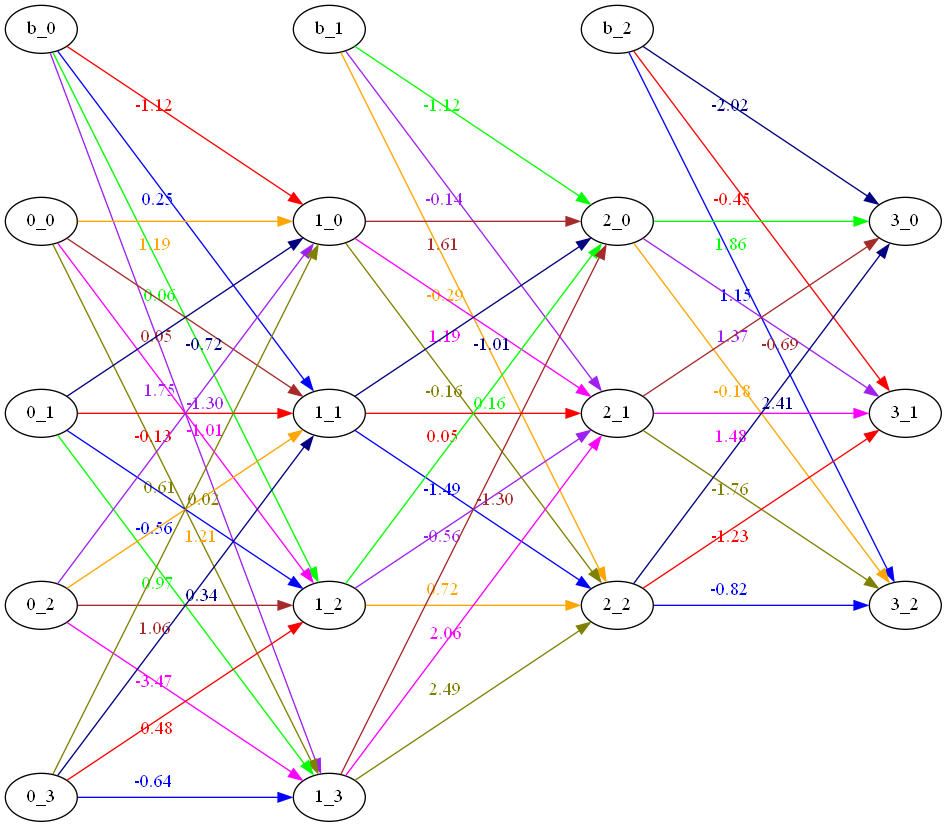

In [51]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
# reminder: implement stop at err < err_thres
data = load_iris()
x = data['data']
y = data['target']
# scale x
x = minmaxscaler(x)
# one hot encode y
n_classes = len(np.unique(y))
y = np.eye(n_classes)[y]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
m = FFNN([4, 4, 3, 3], ['relu', 'relu', 'softmax'], rand_seed=144)
m.fit(x_train, y_train, max_iter=100, lr=0.01, batch_size=5, err_threshold=25, verbose=5)
y_pred = m.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)

print("Accuracy", np.sum(y_pred == y_test) / len(y_test))

m.savetojson('iris.json')
m.draw()

In [52]:
from sklearn.datasets import load_iris
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

iris = load_iris()
x = iris['data']
y = iris['target']

scaler = MinMaxScaler()
x = scaler.fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=144)

mlp = MLPClassifier(hidden_layer_sizes=(4, 4), activation='relu', max_iter=100, learning_rate_init=0.01, batch_size=5, verbose=False, random_state=144)

mlp.fit(x_train, y_train)

accuracy = mlp.score(x_test, y_test)
print("Accuracy:", accuracy)

Accuracy: 0.9666666666666667


[[ -6.07976866]
 [ -4.5307999 ]
 [-10.03287061]
 [ -2.84106186]
 [ -6.19496237]
 [  7.08961399]
 [ -0.25722128]
 [  4.4377042 ]
 [ -7.19177832]
 [-15.45893446]]


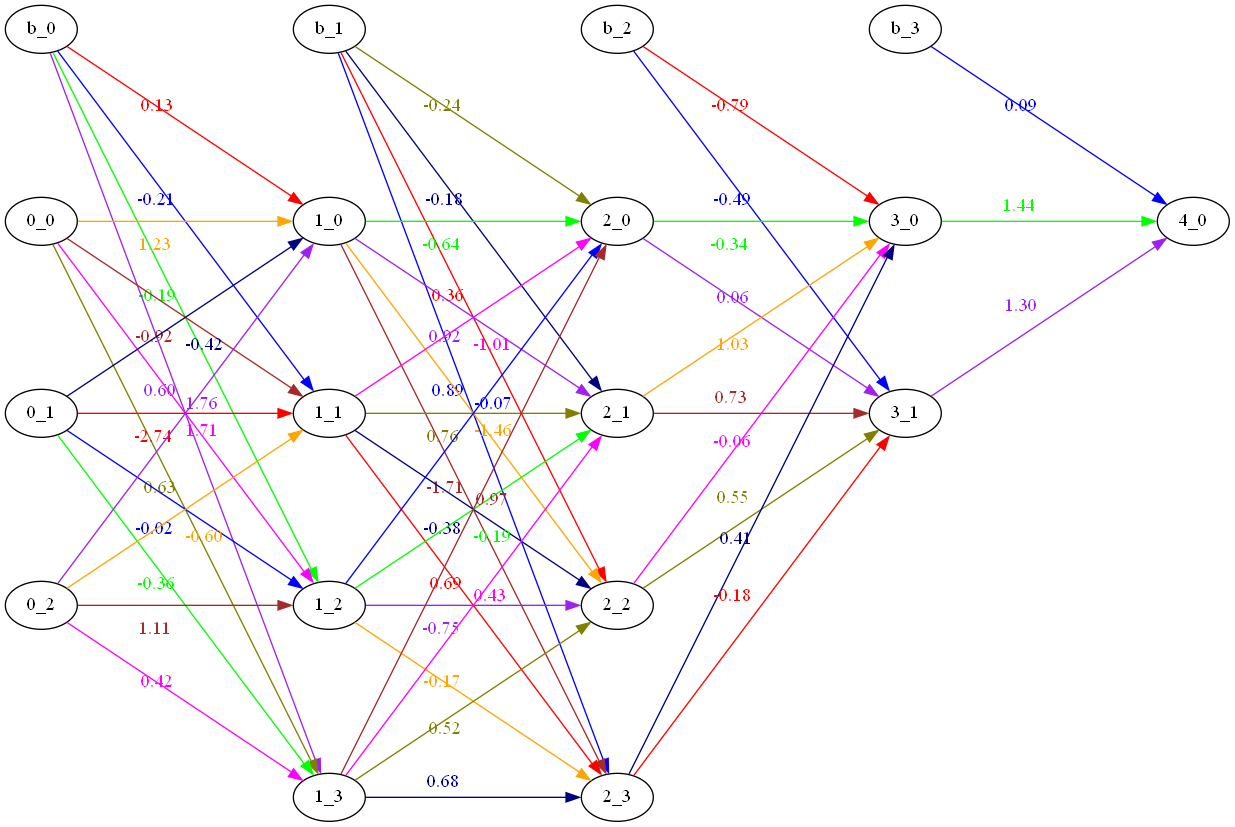

In [53]:
ff = FFNN([3, 4, 4, 2, 1])
np.random.seed(GLOBAL_SEED)
print(ff.forward(np.random.randn(10, 3)))
ff.savetojson('test.json')
ff.draw()

In [54]:
ff2 = FFNN.loadfromjson('test.json')
np.random.seed(GLOBAL_SEED)
print(ff2.forward(np.random.randn(10, 3)))

[[ -6.07976866]
 [ -4.5307999 ]
 [-10.03287061]
 [ -2.84106186]
 [ -6.19496237]
 [  7.08961399]
 [ -0.25722128]
 [  4.4377042 ]
 [ -7.19177832]
 [-15.45893446]]


In [55]:
def test_model(tc_filename):
    print(f"=== Testing {tc_filename} ===")
    with open(tc_filename, 'r') as f:
        data = json5.load(f)
        n_neuron_each_layer = []
        actfns = []
        preweight = data['case']['initial_weights']
        n_neuron_each_layer.append(data['case']['model']['input_size'])

        for layer in data['case']['model']['layers']:
            n_neuron_each_layer.append(layer['number_of_neurons'])
            actfns.append(layer['activation_function'])

        input = np.array(data['case']['input'])
        target = np.array(data['case']['target'])

        model = FFNN(n_neuron_each_layer, actfns, preweight)

        max_iter = data['case']['learning_parameters']['max_iteration']
        lr = data['case']['learning_parameters']['learning_rate']
        batch_size = data['case']['learning_parameters']['batch_size']
        err_threshold = data['case']['learning_parameters']['error_threshold']
        verbose = 1000

        model.fit(input, target, max_iter=max_iter, lr=lr, batch_size=batch_size, err_threshold=err_threshold, verbose=verbose)

        weights_array = model.Wdict['0-to-1']

        print(f"Expected Stopped By: {data['expect']['stopped_by']}")
        print(f"Weights Result:\n{weights_array}")

        if 'final_weights' in data['expect']:
            expected_weights_array = data['expect']['final_weights'][0]
            output_error = np.sum((weights_array - expected_weights_array) ** 2)
            print("Expected Weights:")
            for i in expected_weights_array:
                print(i)
            print(f"Output Error: {output_error}")

        print()

tc_folder = 'testcase'
tc_filename = [
    'linear_small_lr.json',
    'linear_two_iteration.json',
    'linear.json',
    'mlp.json',
    'relu.json',
    'sigmoid_mini_batch_GD.JSON',
    'sigmoid_stochastic_GD.JSON',
    # 'sigmoid.JSON',
    'softmax_error_only.json',
    'softmax.json',
    'sse_only.json',
]
for filename in tc_filename:
    test_model(os.path.join(tc_folder, filename))

=== Testing testcase\linear_small_lr.json ===
epoch 0, error 1.2924615700000002
Stopped By: max iteration
Expected Stopped By: max_iteration
Weights Result:
[[ 0.1012  0.3006  0.1991]
 [ 0.4024  0.201  -0.7019]
 [ 0.1018 -0.799   0.4987]]
Expected Weights:
[0.1008, 0.3006, 0.1991]
[0.402, 0.201, -0.7019]
[0.101, -0.799, 0.4987]
Output Error: 9.600000000000107e-07

=== Testing testcase\linear_two_iteration.json ===
epoch 0, error 0.36369999999999986
epoch 1, error 0.11089300000000005
Stopped By: max iteration
Expected Stopped By: max_iteration
Weights Result:
[[ 0.166  0.338  0.153]
 [ 0.502  0.226 -0.789]
 [ 0.214 -0.718  0.427]]
Expected Weights:
[0.166, 0.338, 0.153]
[0.502, 0.226, -0.789]
[0.214, -0.718, 0.427]
Output Error: 2.9274135154685985e-32

=== Testing testcase\linear.json ===
epoch 0, error 0.36369999999999986
Stopped By: max iteration
Expected Stopped By: max_iteration
Weights Result:
[[ 0.22  0.36  0.11]
 [ 0.64  0.3  -0.89]
 [ 0.28 -0.7   0.37]]
Expected Weights:
[0.22, 